<ipython-input-55-e674fc1f2e03>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


   Show Number    Air Date      Round                         Category
0  4680         2004-12-31  Jeopardy!  HISTORY                        
1  4680         2004-12-31  Jeopardy!  ESPN's TOP 10 ALL-TIME ATHLETES
2  4680         2004-12-31  Jeopardy!  EVERYBODY TALKS ABOUT IT...    
3  4680         2004-12-31  Jeopardy!  THE COMPANY LINE               
4  4680         2004-12-31  Jeopardy!  EPITAPHS & TRIBUTES            
5  4680         2004-12-31  Jeopardy!  3-LETTER WORDS                 
6  4680         2004-12-31  Jeopardy!  HISTORY                        
7  4680         2004-12-31  Jeopardy!  ESPN's TOP 10 ALL-TIME ATHLETES
8  4680         2004-12-31  Jeopardy!  EVERYBODY TALKS ABOUT IT...    
9  4680         2004-12-31  Jeopardy!  THE COMPANY LINE               
Index(['Show Number', 'Air Date', 'Round', 'Category', 'Value', 'Question',
       'Answer', '$ value'],
      dtype='object')
     Air Date      Round                         Category Value
0  2004-12-31  Jeopardy!  HI

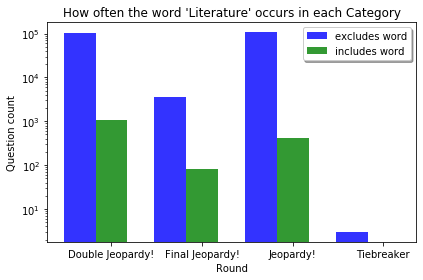


 Literature             Round  excludes  includes proportion 
0           Double Jeopardy!  104858.0  1054.0    1.00%     
1           Final Jeopardy!   3549.0    82.0      2.26%     
2           Jeopardy!         106961.0  423.0     0.39%     
3           Tiebreaker        3.0      NaN        nan%      


In [55]:
import pandas as pd
from matplotlib import pyplot as plt 
import numpy as np
pd.set_option('display.max_colwidth', -1)
import re

# read in the dataset
df = pd.read_csv("jeopardy.csv")

#view the dataset
print( df.iloc[:10, :4])
print( df.iloc[:10, 4:])

# cleaning up the column headings and numeric values
df.rename(columns = lambda x: x.strip(), inplace=True)
df["$ value"] = [ re.sub("\D", "", v) for v in df.Value ]
df["$ value"] = pd.to_numeric(df["$ value"])

# View the data again
print(df.columns)
print( df.iloc[:10, 1:5])
print( df.Round.unique())

# determines if a word all of the words in wordlist are contained in string s
def wordsfilter( s, wordlist, _plurals=False, _subwords=False ):
    wordlist = [w.lower() for w in wordlist]
    if _subwords == False:
        s_string = re.sub(r"\W|_", " ", s).lower()
        s_list = s_string.split()
        s_set = set( s_list)

        if _plurals == False:
            wordlist_set = set(wordlist)
            return wordlist_set.issubset( s_set)
        else:
            included = True
            for w in wordlist:
                if not ((w in s_set) or (w+'s' in s_set)):
                    included = False
            return included
    else:
        included = True
        for w in wordlist:
            if not (w in s.lower()):
                included = False
                #print( w, s)
        return included

# selects rows whose selected columns contains all the words in the word list
def select_rows( the_df, the_wordlist, the_column_name, __plurals=False, __subwords=False):
    return [wordsfilter( the_string, the_wordlist, __plurals, __subwords) for the_string in the_df[the_column_name]]

# gets the column to print out, only the rows meeting the criterion
def get_filtered_columns( the_df, the_wordlist, the_column_name, ___plurals=False, ___subwords=False):
    return the_df[select_rows(the_df, the_wordlist, the_column_name, ___plurals, ___subwords)][the_column_name]

# count many rows there are for
def unique_answers( the_df ):
  return the_df["Answer"].value_counts(ascending=False)

my_wordlist = ["King", "England" ]

print(get_filtered_columns(df, my_wordlist, "Question", True, True))

# What's the average value of questions containing "King"?
king_questions = df[select_rows(df, ["King"], "Question")]
print( df[select_rows(df, ["King"], "Question")]["$ value"].mean() )
print( ( unique_answers( king_questions ))) 

# Which decades is the word "computer" more likely use?
the_word = "date"
the_search_field = "Question"
word_q_rows = df[the_search_field ].apply(lambda s: the_word in s.lower())
word_q = df[word_q_rows]
print( word_q[the_search_field])
word_q_2000s = word_q[word_q["Air Date"].apply(lambda s: "200" in s)]
word_q_1990s = word_q[word_q["Air Date"].apply(lambda s: "199" in s)]
#print( computer_q_2000s[["Air Date", "Question"]] )
print("\nIn 1990s {}s, '{}' occurs {} times ".format( the_search_field, the_word, len(word_q_1990s )))
print("In 2000s {}s, '{}' occurs {} times ".format( the_search_field, the_word, len(word_q_2000s )))


# to investigate the relative prevalence of different words in different Rounds, relative to each other
wrd = 'Literature'
search_field = "Category" # "Category", "Question", or "Answer"
# add new column marking presence vs. absence of the word
df[wrd] = df[search_field].apply(lambda x: wrd.lower() in x.lower())
breakdown_by = "Round"
wrd_count_df = df.groupby([breakdown_by , wrd])[wrd].count().unstack(fill_value=0).stack()
print("\n", wrd_count_df )

# visualize results of relative prevalance of the selected word, for the particular
# search field, in the breakdown (eg. one 'Round' vs. another) 
wrd_count_df=wrd_count_df.reset_index(name = 'count') 
n_groups= len( wrd_count_df)/2
index = np.arange(n_groups)
print( np.arange(n_groups))
print( wrd_count_df["count"])
print( wrd_count_df )

# alternate rows of the groupby df have true vs. false, so we're interested in
# comapring the counts of these alternate rows
exclude_counts = [wrd_count_df.loc[ r*2 ]["count"] for r in np.arange(n_groups)]
include_counts = [wrd_count_df.loc[ r*2+1 ]["count"] for r in np.arange(n_groups)]

# set up the matplotlib barchart
fig, ax = plt.subplots()
bar_width = 0.35
opacity = 0.8

# load bar charts with appropriate data
exclude_rects = plt.bar(index,           exclude_counts, bar_width, alpha=opacity, color='b',label='excludes word')
include_rects = plt.bar(index+bar_width, include_counts, bar_width, alpha=opacity, color='g',label='includes word')

# adorn the barchart with appropriate accoutrements
plt.xlabel(breakdown_by)
plt.ylabel( the_search_field + " count")
ax.set_yscale('log')
plt.title("How often the word '" + wrd + "' occurs in each " + search_field)
plt.xticks(index+bar_width, [wrd_count_df.loc[ r*2 ][breakdown_by] for r in np.arange(n_groups)])
legend = ax.legend(loc='upper right', shadow=True, fontsize='medium')
plt.tight_layout()
plt.show()                              
                              
# make pivot table in order to count true vs. false by breakdown
wrd_count_pvt = pd.pivot_table(df, index=[breakdown_by ], columns=wrd, aggfunc=len, values=search_field).reset_index()
wrd_count_pvt.rename(columns={True: "includes", False: "excludes"}, inplace=True)
wrd_count_pvt["proportion "] = (wrd_count_pvt.includes / (wrd_count_pvt.excludes + wrd_count_pvt.includes)).map("{:.2%}".format)
print("\n", wrd_count_pvt)

In [4]:
# for the jeopardy game, this function will approximate whether the response is possibly 
# correct by checking if any of its words are in the actual correct answer

def word_intersect(try_phrase, target_phrase):
    match = False
    for word in try_phrase.split(" "):
        #print( [word] )
        if wordsfilter(target_phrase, [word]):
            match = True
    return match

In [3]:
# test (demonstrate the function)
word_intersect("ostrich", "the ostrich")

True

In [5]:
# Jeopardy quiz game
import numpy as np
response = ""
print("Enter a response to each question. To exit, type 'quit' as a response")
print("\n")

while response != 'quit':
    print("\n")
    choice = np.random.randint(0, len(df)-1) 
    print( df.iloc[choice, :].Question)
    response = input('--> ')
    answer = df.iloc[choice, :].Answer
    if word_intersect(response, answer):
        print("By jove, you may have got it!")
    print( answer )
print("\nGoodbye")

Enter a response to each question. To exit, type 'quit' as a response




This female folk singer who died in 2008 was called the "voice of the civil rights movement"
--> Joan
Odetta


This nationality fish is a soft & chewy candy
--> swedish
By jove, you may have got it!
Swedish Fish


For a rectangle, one is A=bh; or Similac, for example
--> ?
formula


The WNBA's Sparks
--> ?
Los Angeles


1940: Bad boys are turned into donkeys
--> ?
Pinocchio


The late-afternoon period when bars feature cheap drinks & free snacks
--> happy
By jove, you may have got it!
Happy hour


This train that began service in 1994 links London, Paris & Brussels at up to 186 MPH
--> bullet
Eurostar


Former mortuary science student Jonathan Davis plays bagpipes & sings for this "Freak on a Leash" group
--> ?
Korn


The December 1996 National Rodeo Finals in this Nevada city had $3.2 million in prize money
--> quit
Las Vegas
Goodbye
